# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [0]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim
import spacy

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator, Dataset



SEED = 42
np.random.seed(SEED)

In [0]:
import spacy


spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

In [0]:
classes={
    'neg':0,
    'unsup':1,
    'pos':2
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

In [0]:
dataset = TabularDataset('imdb_master.csv', format='csv', 
                         fields=[(None, None),('type', TEXT),('review', TEXT),('label', LABEL),(None, None)], 
                         skip_header=True)

In [9]:
TEXT.build_vocab(dataset, min_freq=10, vectors="glove.twitter.27B.100d")
len(TEXT.vocab.itos)

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:13, 6.00MB/s]                            
100%|█████████▉| 1193148/1193514 [02:51<00:00, 10116.32it/s]

37965

In [0]:
LABEL.build_vocab(dataset)

In [0]:
train_ds = []
test_ds = []

for el in dataset:
    if el.type[0] == "train":
        train_ds.append(el)
    else:
        test_ds.append(el)

In [0]:
train, test = Dataset(train_ds, fields=[(None, None),('review', TEXT),('label', LABEL)]), Dataset(test_ds, fields=[(None, None),('review', TEXT),('label', LABEL)])
train, valid = train.split(0.7, stratified=True)

In [0]:
device = tt.device('cuda')

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vectors, vocab_size, embed_size, hidden_size, kernels, mode):
        super(MyModel, self).__init__()
        if mode == 'frozen_weights':
            self.embedding = nn.Embedding.from_pretrained(vectors, freeze=True)
        elif mode == 'pretrained_weights':
            self.embedding = nn.Embedding.from_pretrained(vectors, freeze=False)
        elif mode == 'random_weights':
            self.embedding = nn.Embedding.from_pretrained(nn.init.uniform_(tt.empty(vocab_size, embed_size)), freeze=False)
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [0]:
def train_nn(model, train_iter, val_iter, n_batches, optimizer, criterion, n_epochs=20, 
             early_stopping=4
            ):
    sw = None
        
    early_stopping_epochs = 0
    prev_loss = 100500
    history = []
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)
    
    for epoch in range(n_epochs):
        
        model.train()
        train_loss = []
        
            
        for batch in train_iter:
            b_rev = batch.review[0].to(device)
            optimizer.zero_grad()
            b_lab = batch.label.to(device)
            prediction = model.forward(b_rev)
            
            loss = criterion(prediction, b_lab)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.data.detach().item())
        
        #print(train_loss)
        train_loss = np.mean(train_loss)
                
                
        # validation on epoch
        model.eval()
        val_loss = []

        with tt.no_grad():
            for batch in val_iter:
                b_rev = batch.review[0].to(device)
                b_lab = batch.label.to(device)
                prediction = model.forward(b_rev)
                loss = criterion(prediction, b_lab)
                loss = loss.data.detach().item()
                val_loss.append( loss )

        val_loss = np.mean(val_loss)

        print('validation loss=%.4f' % val_loss)

        if sw:
            sw.add_scalar('Validation/Loss', val_loss, epoch)
        
        scheduler.step(val_loss)

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'learning_rate': optimizer.param_groups[0]['lr']
        })

        if early_stopping > 0:
            if val_loss > prev_loss:
                early_stopping_epochs = 1
            else:
                early_stopping_epochs = 0

            if early_stopping_epochs >= early_stopping:
                if verbose:
                    print('Early stopping, best val_loss=%.4f' % prev_loss)
                break

            prev_loss = min(prev_loss, val_loss)

    return pd.DataFrame(history)

Using pretrained word embeddings with frozen weights. torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True). 

In [0]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(vectors=TEXT.vocab.vectors,
                vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                mode='frozen_weights'
               )
model.to(device)
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review),
#     sort_within_batch=True,
)

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [0]:
n_batches = int(np.ceil(len(train_iterator.dataset) / batch_size))

In [28]:
frozen_res = train_nn(model, train_iterator, valid_iterator, n_batches, optimizer, criterion, 
         n_epochs=10
        )

validation loss=1.0202
validation loss=1.0124
validation loss=1.0242
validation loss=1.0301
validation loss=1.0197
Epoch     4: reducing learning rate of group 0 to 1.0000e-05.
validation loss=1.0089
validation loss=1.0180
validation loss=1.0118
validation loss=1.0191
Epoch     8: reducing learning rate of group 0 to 1.0000e-06.
validation loss=1.0177


In [0]:
test_loss = []

with tt.no_grad():
    for batch in test_iterator:
        b_rev = batch.review[0].to(device)
        b_lab = batch.label.to(device)
        prediction = model.forward(b_rev)
        loss = criterion(prediction, b_lab)
        loss = loss.data.detach().item()
        test_loss.append( loss )

frozen_loss = np.mean(test_loss)

In [0]:
tt.cuda.empty_cache()

model = MyModel(vectors=TEXT.vocab.vectors,
                vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                mode='pretrained_weights'
               )
model.to(device)

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)

In [32]:
not_frozen_res = train_nn(model, train_iterator, valid_iterator, n_batches, optimizer, criterion, 
         n_epochs=10
        )

validation loss=0.9302
validation loss=1.1532
validation loss=1.6466
validation loss=2.0704
Epoch     3: reducing learning rate of group 0 to 1.0000e-04.
validation loss=2.8245
validation loss=3.1929
validation loss=3.4295
Epoch     6: reducing learning rate of group 0 to 1.0000e-05.
validation loss=3.4679
validation loss=3.5089
validation loss=3.5468
Epoch     9: reducing learning rate of group 0 to 1.0000e-06.


In [0]:
test_loss = []

with tt.no_grad():
    for batch in test_iterator:
        b_rev = batch.review[0].to(device)
        b_lab = batch.label.to(device)
        prediction = model.forward(b_rev)
        loss = criterion(prediction, b_lab)
        loss = loss.data.detach().item()
        test_loss.append( loss )

not_frozen_loss = np.mean(test_loss)

In [0]:
tt.cuda.empty_cache()

model = MyModel(vectors=TEXT.vocab.vectors,
                vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                mode='random_weights'
               )
model.to(device)

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)

In [35]:
random_res = train_nn(model, train_iterator, valid_iterator, n_batches, optimizer, criterion, 
         n_epochs=10
        )

validation loss=0.8152
validation loss=1.0319
validation loss=1.1916
validation loss=1.4980
Epoch     3: reducing learning rate of group 0 to 1.0000e-04.
validation loss=1.4962
validation loss=1.5938
validation loss=1.7511
Epoch     6: reducing learning rate of group 0 to 1.0000e-05.
validation loss=1.7206
validation loss=1.7002
validation loss=1.7420
Epoch     9: reducing learning rate of group 0 to 1.0000e-06.


In [0]:
test_loss = []

with tt.no_grad():
    for batch in test_iterator:
        b_rev = batch.review[0].to(device)
        b_lab = batch.label.to(device)
        prediction = model.forward(b_rev)
        loss = criterion(prediction, b_lab)
        loss = loss.data.detach().item()
        test_loss.append( loss )

random_loss = np.mean(test_loss)


### current learning rate against number of epochs
(random совпадает с not_frozen, поэтому одна толще, другая тоньше, чтобы можно было увидеть обе)


Text(0, 0.5, 'learning rate')

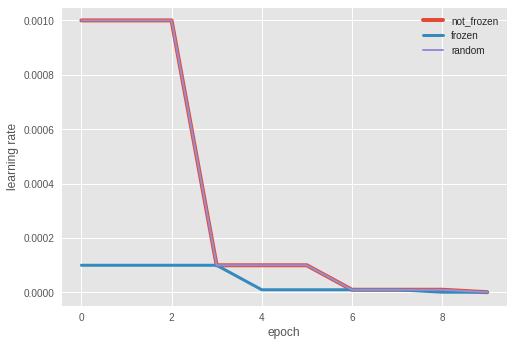

In [50]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(range(0, len(not_frozen_res)), not_frozen_res.learning_rate, label='not_frozen', linewidth=4)
plt.plot(range(0, len(frozen_res)), frozen_res.learning_rate, label='frozen', linewidth=3)
plt.plot(range(0, len(random_res)), random_res.learning_rate, label='random', linewidth=2)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('learning rate')

### Validation curve

Text(0, 0.5, 'cross-entropy loss')

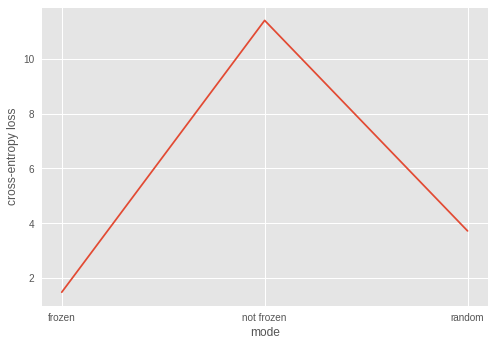

In [57]:
plt.plot([0, 1, 2], [frozen_loss, not_frozen_loss, random_loss])
plt.xticks([0, 1, 2], ['frozen', 'not frozen', 'random'])
plt.xlabel('mode')
plt.ylabel('cross-entropy loss')